In [1]:
!pip install tensorflow_hub

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow-text

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
import tensorflow_hub as hub
import tensorflow_text as text
import json
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "svg"

In [4]:
# Import dataset already preprocessed
dataset = pd.read_csv("src/spam_clean.csv", encoding="ISO-8859-1")
dataset.head()

,Unnamed: 0,target,SMS,target_num,SMS_clean,SMS_encoded,len_SMS
0,0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[3621, 233, 448, 463, 943, 35, 52, 205, 944, 7...",14
1,1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[10, 194, 464, 289, 1, 1460]",6
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 298, 3, 535, 667, 33, 1461, 856, 424, 146...",22
3,3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[1, 125, 150, 2362, 1, 85]",6
4,4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live,"[712, 22, 668, 129]",4


In [5]:
dataset.describe(include='all')

,Unnamed: 0,target,SMS,target_num,SMS_clean,SMS_encoded,len_SMS
count,5555.000000,5555,5555,5555.000000,5555,5555,5555.000000
unique,NaN,2,5152,NaN,5086,5085,NaN
top,NaN,ham,"Sorry, I'll call later",NaN,sorry ill later,"[31, 17, 40]",NaN
freq,NaN,4808,30,NaN,30,30,NaN
mean,2785.340234,NaN,NaN,0.134473,NaN,NaN,8.246625
std,1608.728782,NaN,NaN,0.341191,NaN,NaN,6.399526
min,0.000000,NaN,NaN,0.000000,NaN,NaN,1.000000
25%,1393.500000,NaN,NaN,0.000000,NaN,NaN,4.000000
50%,2784.000000,NaN,NaN,0.000000,NaN,NaN,6.000000
75%,4177.500000,NaN,NaN,0.000000,NaN,NaN,12.000000


# Transfert Learning

I chose to run a BERT (Bidirectional Encoder Representations from Transformers) model to classify the SMS.  
This is a pre-trained model that offers vector-space representations of words using the Transformer architecture. It was trained in a non-supervised manner on large Wikipedia corpus of texts.  
The advantage is that some versions of the model were fully developped with TensorFlow.  
The model has a lot of variants, depending on 3 parameters : L the number of layers, H the hidden size, and A the number of attention heads.  
I chose the smallest version of Small BERT : 'bert_en_uncased_L-2_H-128_A-2'. Indeed, with a very small dataset, we probably don't need to run huge models. This model is a small version of BERT with fewer and smaller Transformer blocks.  
  
Before running the BERT embedding model, we need to preprocess the text with a matching model that is also provided by TensorFlow Hub. I used the 'bert_en_uncased_preprocess/3' model.  

Here are all the links that helped me building the model :  
https://blog.tensorflow.org/2020/12/making-bert-easier-with-preprocessing-models-from-tensorflow-hub.html  
https://tfhub.dev/google/collections/bert/1  
https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en  
https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset['SMS_clean'], dataset['target_num'], test_size=0.3, random_state=42, stratify = dataset['target_num'])

In [7]:
X_train[0:15]

1038                       today college able atten class
763        wish family merry x mas happy new year advance
5066    amazing   rearrange letter meaning dormitory  ...
3889                                     right brah later
1136    messagesome text miss sendername miss number m...
4561    congratulation ur award 500 cd voucher 125gift...
2250                                check head drop stuff
5478    cool shall tip home drop later let town tonigh...
750       important customer service announcement premier
970                              yup thk e shop close lor
1861    mmmm   fuck   fair   know weakness   grin push...
4978                               look addie monday suck
4700    hey happen u switch ur cell d day good u care ...
4467                                  noit ful song lyric
3394    hey das cool iknow 2 wellda peril studentfinan...
Name: SMS_clean, dtype: object

In [8]:
# Creating the tensor datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2023-01-31 09:40:38.470401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-31 09:40:38.470432: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 09:40:38.470459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lise-PC): /proc/driver/nvidia/version does not exist
2023-01-31 09:40:38.470791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Creating the batches
train_ds = train_ds.shuffle(len(train_ds)).batch(64)
test_ds = test_ds.shuffle(len(test_ds)).batch(64)

In [10]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path_TL = "trainingTL/cp-{epoch:04d}.ckpt" # the path where checkpoint files will be stored

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_TL, 
    verbose=1,
    save_weights_only=True,
    save_freq=1*len(train_ds))

In [11]:
# Building the model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing') # matching preprocessing model for BERT
encoder_inputs = preprocessor(text_input)
#encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/2", trainable=True, name = 'BERT_encoder')
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2", trainable=True, name = 'BERT_encoder')
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 128].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 128].

# Neural network layers
net = tf.keras.layers.Dropout(0.1)(pooled_output)
net = tf.keras.layers.BatchNormalization()(net)     # I added this layer otherwise the model does not train 
net = Dense(1, activation='sigmoid', name='classifier')(net)    # output layer with one neuron and sigmoid activation function because we need 0 or 1 as a result

# Use inputs and outputs to construct a final model
model_TL = tf.keras.Model(text_input, net)

# Save the weights using the `checkpoint_path` format
model_TL.save_weights(checkpoint_path_TL.format(epoch=0))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
model_TL.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

We can notice that the number of parameters to train (4 386 562) is huge compared to the 5 555 rows of the dataset.

In [13]:
model_TL.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [14]:
model_TL.fit(train_ds,
          epochs=20, 
          validation_data=test_ds,
          callbacks=[cp_callback]
          )

Epoch 1/20
60/61 [============================>.] - ETA: 0s - loss: 0.2071 - binary_accuracy: 0.9404
Epoch 1: saving model to trainingTL/cp-0001.ckpt
61/61 [==============================] - 42s 649ms/step - loss: 0.2054 - binary_accuracy: 0.9408 - val_loss: 0.1288 - val_binary_accuracy: 0.9754
Epoch 2/20
60/61 [============================>.] - ETA: 0s - loss: 0.0845 - binary_accuracy: 0.9854
Epoch 2: saving model to trainingTL/cp-0002.ckpt
61/61 [==============================] - 36s 596ms/step - loss: 0.0846 - binary_accuracy: 0.9853 - val_loss: 0.0965 - val_binary_accuracy: 0.9826
Epoch 3/20
60/61 [============================>.] - ETA: 0s - loss: 0.0472 - binary_accuracy: 0.9911
Epoch 3: saving model to trainingTL/cp-0003.ckpt
61/61 [==============================] - 36s 596ms/step - loss: 0.0466 - binary_accuracy: 0.9913 - val_loss: 0.0958 - val_binary_accuracy: 0.9850
Epoch 4/20
60/61 [============================>.] - ETA: 0s - loss: 0.0193 - binary_accuracy: 0.9969
Epoch 4: sa

In [15]:
# model_TL.save("content/model_smallBERT_2-128-2.h5")

In [16]:
# json.dump(model_TL.history.history, open("content/smallBERT_2-128-2_history.json", 'w'))

# Compare results with the GRU model

In [17]:
TL_history = json.load(open("content/smallBERT_2-128-2_history.json", 'r'))
GRU_history = json.load(open("content/GRU_history.json", 'r'))

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["loss"],
                    mode='lines',
                    name='loss_GRU',
                    marker_color = 'darkgreen'))
fig.add_trace(go.Scatter(y=GRU_history["val_loss"],
                    mode='lines',
                    name='val_loss_GRU',
                    marker_color = 'limegreen'))
fig.add_trace(go.Scatter(y=TL_history["loss"],
                    mode='lines',
                    name='loss_smallBERT',
                    marker_color = 'darkred'))
fig.add_trace(go.Scatter(y=TL_history["val_loss"],
                    mode='lines',
                    name='val_loss_smallBERT',
                    marker_color = 'tomato'))
fig.update_layout(title='Loss for GRU and small BERT', title_x = 0.5,
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy_GRU',
                    marker_color = 'darkgreen'))
fig.add_trace(go.Scatter(y=GRU_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy_GRU',
                    marker_color = 'limegreen'))
fig.add_trace(go.Scatter(y=TL_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy_smallBERT',
                    marker_color = 'darkred'))
fig.add_trace(go.Scatter(y=TL_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy_smallBERT',
                    marker_color = 'tomato'))
fig.update_layout(title='Accuracy for GRU and small BERT', title_x = 0.5,
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

We can see that the training process is much faster with small BERT than GRU. It is logical because the small BERT model is already pre-trained.  
The small BERT model is also more stable when the training is repeated.

In [23]:
# Loading small BERT model at checkpoint xxx epochs
model_TL.load_weights("trainingTL/cp-0010.ckpt")

In [24]:
pred_train = model_TL.predict(X_train)
pred_test = model_TL.predict(X_test)

53/53 [==============================] - 3s 60ms/step


In [25]:
pred_test

array([[2.2574069e-04],
       [2.2561007e-04],
       [2.2842456e-04],
       ...,
       [2.3296742e-04],
       [2.2671004e-04],
       [1.0000000e+00]], dtype=float32)

In [26]:
# convert the output of sigmoid function into 0 or 1
y_train_pred = tf.cast(tf.greater(pred_train, 0.5), tf.int32)
y_test_pred = tf.cast(tf.greater(pred_test, 0.5), tf.int32)

In [27]:
y_test_pred

<tf.Tensor: shape=(1667, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]], dtype=int32)>

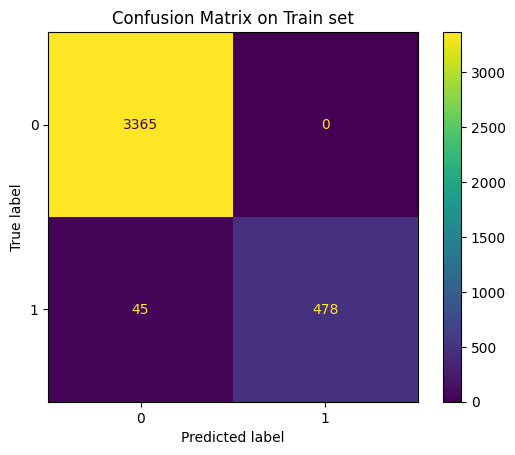

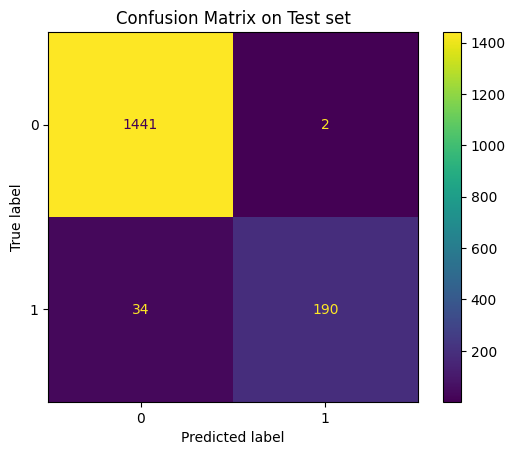

In [28]:
# Visualize confusion matrices for the small BERT model
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax)

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax)
plt.show()

In [29]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1443
           1       0.99      0.85      0.91       224

    accuracy                           0.98      1667
   macro avg       0.98      0.92      0.95      1667
weighted avg       0.98      0.98      0.98      1667



The GRU and small BERT models offer similar performances. The GRU is smaller, which is sufficient for this small dataset. On the other hand, the small BERT is probably more stable.  If we had a larger dataset, we will probably choose to use the small BERT model.